In [1]:
# Import section
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from veloxchem.veloxchemlib import bohr_in_angstroms

In [2]:
def f(x, y):
    return -x**4 / 40.0 + x**2 - y**2 - 50.0 * np.exp(-(x**2 + y**2)/10.0)

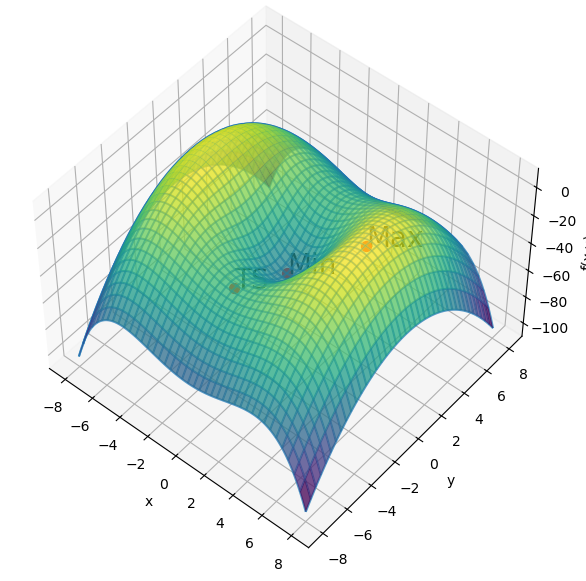

In [3]:
# Let's represent the function graphically
# First, we need to create the X,Y grid
x = np.arange(-8, 8.01, 0.1)
y = np.arange(-8, 8.01, 0.1)
X, Y = np.meshgrid(x, y)

# Next, we have to calculate the value of f at each point on the grid
Z = f(X, Y)

# Add a wireframe and a 
# partly translucent surface plot on top of each other
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, alpha=0.75)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.75)

# Side view
ax.view_init(50, -50)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')

# Label the special points on the surface
# Minimum
x1 = 0
y1 = 0
st = 'Min'

ax.scatter(x1, y1, f(x1, y1), s=50, color='red')
ax.text(x1, y1, f(x1, y1), st, size=20, color='black')

# Saddle point
x2 = 0
y2 = -4.2
st = 'TS'

ax.scatter(x2, y2, f(x2, y2), s=50, color='red')
ax.text(x2, y2, f(x2, y2), st, size=20, color='black')

# Maximum
x3 = 5.25
y3 = 0
st = 'Max'

ax.scatter(x3, y3, f(x3, y3), s=50, color='red')
ax.text(x3, y3, f(x3, y3), st, size=20, color='black')

plt.show()

In [4]:
# Now we need to calculate the gradient
def grad_f(x, y):

    partial_x = -(x**3) / 10.0 + 2 * x + 10.0 * x * np.exp(-(x**2 + y**2)/10.0)
    partial_y = -2 * y + 10.0 * y * np.exp(-(x**2 + y**2)/10.0)
    
    return np.array([partial_x, partial_y])

In [5]:
def gradient_descent(x0, y0, function, gradient, k = 0.025,
                     conv_thresh=1e-5, max_iter=100):
    """ Performs an optimization using the gradient descent algorithm
        for a two-variable function.

        :param x0         : the starting x-coordinate.
        :param y0         : the starting y-coordinate.
        :param function   : the function.
        :param gradient   : the gradient.
        :param k          : gradient descent step size.
        :param conv_thresh: the convergence threshold.
        :param max_iter   : the maximum number of iterations.
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)

    i = 0 # current iteration
    
    grad_norm = np.linalg.norm(g0)
    opt_data = {'points': [(x0, y0)], 'function_values':[f0], 'gradient_norms': [grad_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (grad_norm >= conv_thresh)):
        # Update x and y to take a step in the opposite direction of the gradient
        x = x0 - k * g0[0]
        y = y0 - k * g0[1]

        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)

        grad_norm = np.linalg.norm(g)

        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(grad_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        g0 = g

        if grad_norm < conv_thresh:
            print("Converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [6]:
gradient_descent_opt_data = gradient_descent(x0=-3.0, y0=1.9, function=f,
                                             gradient=grad_f,
                                             k=0.025, conv_thresh=1e-5,
                                             max_iter=100)

Converged in 69 iterations!


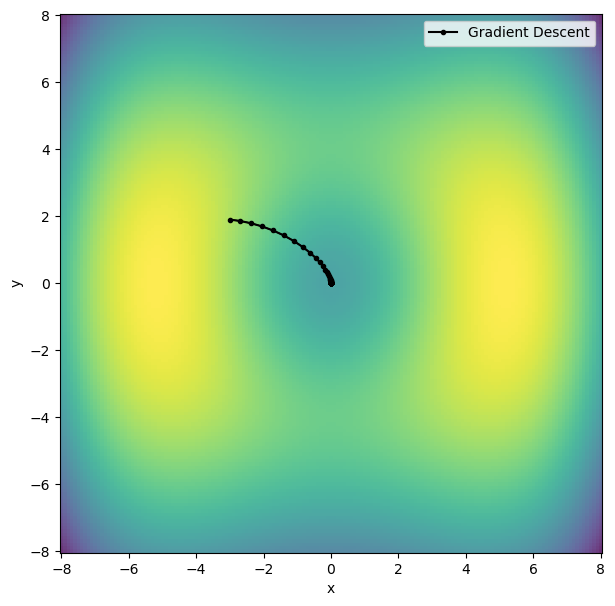

In [7]:
traj_gradient_descent = gradient_descent_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line, = ax.plot(xpath, ypath, '.-', color="black", label="Gradient Descent")
ax.add_patch(patch)

plt.legend()
plt.show()

In [8]:
def conjugate_gradient(x0, y0, function, gradient, k = 0.025,
                       conv_thresh=1e-5, max_iter=100,
                       method="Fletcher-Reeves"):
    """ Performs an optimization using the conjugate gradient algorithm
        for a two-variable function.

        :param x0         : the starting x-coordinate.
        :param y0         : the starting y-coordinate.
        :param function   : the function.
        :param gradient   : the gradient.
        :param k          : conjugate gradient step size.
        :param conv_thresh: the convergence threshold.
        :param max_iter   : the maximum number of iterations.
        :param method     : the conjugate gradient method
                            (Fletcher-Reeves, or Polak-Ribiere).
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)

    i = 0 # current iteration
    # the first step in conjugate gradient is the same as for gradient descent.
    h0 = g0 
    
    g0_norm = np.linalg.norm(g0)
    opt_data = {'points': [(x0, y0)], 'function_values':[f0],
                'gradient_norms': [g0_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (g0_norm >= conv_thresh)):
        # Update x and y to take a step in the opposite direction
        # of the gradient
        x = x0 - k * h0[0]
        y = y0 - k * h0[1]
        
        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)

        g_norm = np.linalg.norm(g)

        if method == "Fletcher-Reeves":
            gamma = g_norm**2 / g0_norm**2
        elif method == "Polak-Ribiere":
            gamma = np.dot((g - g0).T, g) / g0_norm**2
        else:
            error_txt = "Unknown conjugate gradient method."
            error_txt += " Please use Fletcher-Reeves or Polak-Ribiere."
            raise ValueError(error_txt)
        h = g + gamma * h0
        
        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(g_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        h0 = h
        g0 = g
        g0_norm = g_norm

        if g_norm < conv_thresh:
            print(method + " converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [9]:
cg_fletcher_reeves_opt_data = conjugate_gradient(x0=-3.0, y0=1.9, function=f, gradient=grad_f,
                                                 k=0.025, conv_thresh=1e-5, max_iter=120,
                                                 method="Fletcher-Reeves")

cg_polak_ribiere_opt_data = conjugate_gradient(x0=-3.0, y0=1.9, function=f, gradient=grad_f,
                                               k=0.025, conv_thresh=1e-5, max_iter=120,
                                               method="Polak-Ribiere")

Fletcher-Reeves converged in 118 iterations!
Polak-Ribiere converged in 81 iterations!


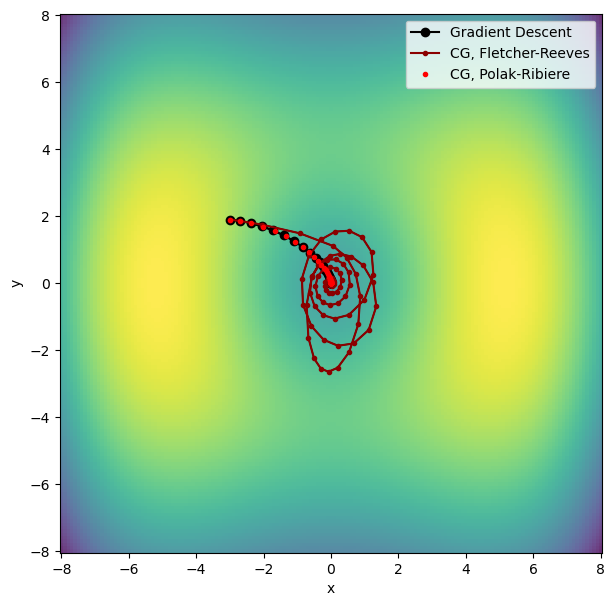

In [10]:
traj_cg_fr = cg_fletcher_reeves_opt_data['points']
traj_cg_pr = cg_polak_ribiere_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line = ax.plot(xpath, ypath, 'o-', color="black", label="Gradient Descent")
ax.add_patch(patch)

# Plot the conjugate gradient trajectory
Traj_fr = Path(traj_cg_fr)
patch_fr = PathPatch(Traj_fr, facecolor='none')
xpath_fr, ypath_fr = zip(*Traj_fr.vertices)
line_fr = ax.plot(xpath_fr, ypath_fr, '.-', color="darkred", label="CG, Fletcher-Reeves")
ax.add_patch(patch_fr)

Traj_pr = Path(traj_cg_pr)
patch_pr = PathPatch(Traj_pr, facecolor='none')
xpath_pr, ypath_pr = zip(*Traj_pr.vertices)
line_pr = ax.plot(xpath_pr, ypath_pr, '.', color="red", label="CG, Polak-Ribiere")
ax.add_patch(patch_pr)

plt.legend()
plt.show()

In [11]:
def hessian_f(x, y):

    partial_xx = ( -3 * x**2 / 10.0 + 2 + 10.0 * np.exp(-(x**2 + y**2)/10.0)
                  - 2 * x**2 * np.exp(-(x**2 + y**2)/10.0)
                 )
    partial_xy =  - 2 * x * y * np.exp(-(x**2 + y**2)/10.0)
    partial_yx = partial_xy
    partial_yy = -2 + 10.0 * np.exp(-(x**2 + y**2)/10.0) - 2 * y**2 * np.exp(-(x**2 + y**2)/10.0)
    
    return np.array([[partial_xx, partial_xy],[partial_yx, partial_yy]])

In [12]:
def newton_raphson(x0, y0, function, gradient, hessian, conv_thresh=1e-5,
                   max_iter=100, trust_radius=None):
    """ Performs an optimization using the Newton-Raphson algorithm
        for a two-variable function.

        :param x0          : the starting x-coordinate.
        :param y0          : the starting y-coordinate.
        :param function    : the function.
        :param gradient    : the gradient.
        :param hessian     : the Hessian.
        :param conv_thresh : the convergence threshold.
        :param max_iter    : the maximum number of iterations.
        :param trust_radius: the trust radius.
    """
    f0 = function(x0, y0)
    g0 = gradient(x0, y0)
    h0 = hessian(x0, y0)

    # the inverse of the Hessian matrix
    inv_h0 = np.linalg.inv(h0)

    i = 0 # current iteration
    
    g_norm = np.linalg.norm(g0)
    delta_r = -np.dot(inv_h0, g0)
    
    opt_data = {'points': [(x0, y0)], 'function_values':[f0],
                'gradient_norms': [g_norm]}

    # Loop until either converged or maximum iteration threshold reached
    while ((i < max_iter) and (g_norm >= conv_thresh)):
        if trust_radius is not None:
            steplen = np.linalg.norm(delta_r)
            if steplen > trust_radius:
                # If proposed step exceeds trust radius,
                # then decrease step length to trust radius
                delta_r /= (steplen / trust_radius)
            
        # Update x and y
        x = x0 + delta_r[0]
        y = y0 + delta_r[1]

        # Calculate new function value and new gradient
        f = function(x, y)
        g = gradient(x, y)
        h = hessian(x, y)
        
        inv_h = np.linalg.inv(h)
        delta_r = -np.dot(inv_h, g)
        g_norm = np.linalg.norm(g)
      
        # Save the optimization data
        opt_data['points'].append((x, y))
        opt_data['function_values'].append(f)
        opt_data['gradient_norms'].append(g_norm)

        # Update x0, y0, and g0 for the next iteration
        i += 1
        x0 = x
        y0 = y
        
        if g_norm < conv_thresh:
            print("Converged in %d iterations!" % i)
            return opt_data
            
    print("Did not converge after %d iterations." % i)
    return opt_data

In [13]:
newton_raphson_opt_data = newton_raphson(x0=-3.0, y0=1.9, function=f,
                                         gradient=grad_f,
                                         hessian=hessian_f,
                                         conv_thresh=1e-5,
                                         max_iter=120,
                                         trust_radius=1.0)

Converged in 7 iterations!


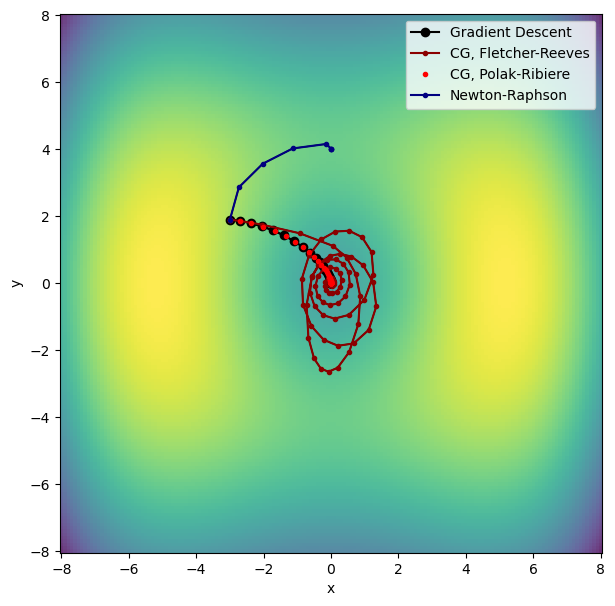

In [14]:
traj_newton_raphson = newton_raphson_opt_data['points']

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.pcolormesh(X, Y, Z, cmap='viridis', alpha=0.8)

# Set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the gradient descent trajectory
Traj = Path(traj_gradient_descent)
patch = PathPatch(Traj, facecolor='none')
xpath, ypath = zip(*Traj.vertices)
line = ax.plot(xpath, ypath, 'o-', color="black", label="Gradient Descent")
ax.add_patch(patch)

# Plot the conjugate gradient trajectory
Traj_fr = Path(traj_cg_fr)
patch_fr = PathPatch(Traj_fr, facecolor='none')
xpath_fr, ypath_fr = zip(*Traj_fr.vertices)
line_fr = ax.plot(xpath_fr, ypath_fr, '.-', color="darkred", label="CG, Fletcher-Reeves")
ax.add_patch(patch_fr)

Traj_pr = Path(traj_cg_pr)
patch_pr = PathPatch(Traj_pr, facecolor='none')
xpath_pr, ypath_pr = zip(*Traj_pr.vertices)
line_pr = ax.plot(xpath_pr, ypath_pr, '.', color="red", label="CG, Polak-Ribiere")
ax.add_patch(patch_pr)

# Plot the Newton-Raphson trajectory
Traj_nr = Path(traj_newton_raphson)
patch_nr = PathPatch(Traj_nr, facecolor='none')
xpath_nr, ypath_nr = zip(*Traj_nr.vertices)
line_nr = ax.plot(xpath_nr, ypath_nr, '.-', color="navy", label="Newton-Raphson")
ax.add_patch(patch_nr)

plt.legend()
plt.show()